In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
import sys
sys.path.append("..")

import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import SineDataset, SineCosineDataset, CosineDataset
from tiny.utils import plot_point_cloud, plot_point_clouds, count_parameters
from tiny import Diffusion, PointCloudDDPM, PointCloudDiffusionTrainer, UnconditionalPointCloudDiT
from tiny.model import PointDiffusionTransformer
from torch.utils.data import ConcatDataset

In [11]:
"""
Based on https://github.com/openai/guided-diffusion/blob/22e0df8183507e13a7813f8d38d51b072ca1e67c/guided_diffusion/gaussian_diffusion.py
"""

import math
from typing import Any, Dict, Iterable, Optional, Sequence, Union

import numpy as np
import torch as th


def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    """
    This is the deprecated API for creating beta schedules.

    See get_named_beta_schedule() for the new library of schedules.
    """
    if beta_schedule == "linear":
        betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    else:
        raise NotImplementedError(beta_schedule)
    assert betas.shape == (num_diffusion_timesteps,)
    return betas


def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.

    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        scale = 1000 / num_diffusion_timesteps
        return get_beta_schedule(
            "linear",
            beta_start=scale * 0.0001,
            beta_end=scale * 0.02,
            num_diffusion_timesteps=num_diffusion_timesteps,
        )
    elif schedule_name == "cosine":
        return betas_for_alpha_bar(
            num_diffusion_timesteps,
            lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2,
        )
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")


def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    """
    Create a beta schedule that discretizes the given alpha_t_bar function,
    which defines the cumulative product of (1-beta) over time from t = [0,1].

    :param num_diffusion_timesteps: the number of betas to produce.
    :param alpha_bar: a lambda that takes an argument t from 0 to 1 and
                      produces the cumulative product of (1-beta) up to that
                      part of the diffusion process.
    :param max_beta: the maximum beta to use; use values lower than 1 to
                     prevent singularities.
    """
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)


def space_timesteps(num_timesteps, section_counts):
    """
    Create a list of timesteps to use from an original diffusion process,
    given the number of timesteps we want to take from equally-sized portions
    of the original process.
    For example, if there's 300 timesteps and the section counts are [10,15,20]
    then the first 100 timesteps are strided to be 10 timesteps, the second 100
    are strided to be 15 timesteps, and the final 100 are strided to be 20.
    :param num_timesteps: the number of diffusion steps in the original
                          process to divide up.
    :param section_counts: either a list of numbers, or a string containing
                           comma-separated numbers, indicating the step count
                           per section. As a special case, use "ddimN" where N
                           is a number of steps to use the striding from the
                           DDIM paper.
    :return: a set of diffusion steps from the original process to use.
    """
    if isinstance(section_counts, str):
        if section_counts.startswith("ddim"):
            desired_count = int(section_counts[len("ddim") :])
            for i in range(1, num_timesteps):
                if len(range(0, num_timesteps, i)) == desired_count:
                    return set(range(0, num_timesteps, i))
            raise ValueError(f"cannot create exactly {num_timesteps} steps with an integer stride")
        elif section_counts.startswith("exact"):
            res = set(int(x) for x in section_counts[len("exact") :].split(","))
            for x in res:
                if x < 0 or x >= num_timesteps:
                    raise ValueError(f"timestep out of bounds: {x}")
            return res
        section_counts = [int(x) for x in section_counts.split(",")]
    size_per = num_timesteps // len(section_counts)
    extra = num_timesteps % len(section_counts)
    start_idx = 0
    all_steps = []
    for i, section_count in enumerate(section_counts):
        size = size_per + (1 if i < extra else 0)
        if size < section_count:
            raise ValueError(f"cannot divide section of {size} steps into {section_count}")
        if section_count <= 1:
            frac_stride = 1
        else:
            frac_stride = (size - 1) / (section_count - 1)
        cur_idx = 0.0
        taken_steps = []
        for _ in range(section_count):
            taken_steps.append(start_idx + round(cur_idx))
            cur_idx += frac_stride
        all_steps += taken_steps
        start_idx += size
    return set(all_steps)


class GaussianDiffusion:
    """
    Utilities for training and sampling diffusion models.

    Ported directly from here:
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/diffusion_utils_2.py#L42

    :param betas: a 1-D array of betas for each diffusion timestep from T to 1.
    :param model_mean_type: a string determining what the model outputs.
    :param model_var_type: a string determining how variance is output.
    :param loss_type: a string determining the loss function to use.
    :param discretized_t0: if True, use discrete gaussian loss for t=0. Only
                           makes sense for images.
    :param channel_scales: a multiplier to apply to x_start in training_losses
                           and sampling functions.
    """

    def __init__(
        self,
        *,
        betas: Sequence[float],
        model_mean_type: str,
        model_var_type: str,
        loss_type: str,
        discretized_t0: bool = False,
        channel_scales: Optional[np.ndarray] = None,
        channel_biases: Optional[np.ndarray] = None,
    ):
        self.model_mean_type = model_mean_type
        self.model_var_type = model_var_type
        self.loss_type = loss_type
        self.discretized_t0 = discretized_t0
        self.channel_scales = channel_scales
        self.channel_biases = channel_biases

        # Use float64 for accuracy.
        betas = np.array(betas, dtype=np.float64)
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        alphas = 1.0 - betas
        self.alphas_cumprod = np.cumprod(alphas, axis=0)
        self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
        self.alphas_cumprod_next = np.append(self.alphas_cumprod[1:], 0.0)
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = np.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod - 1)

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.posterior_log_variance_clipped = np.log(
            np.append(self.posterior_variance[1], self.posterior_variance[1:])
        )
        self.posterior_mean_coef1 = (
            betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - self.alphas_cumprod)
        )

    def get_sigmas(self, t):
        return _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, t.shape)

    def q_mean_variance(self, x_start, t):
        """
        Get the distribution q(x_t | x_0).

        :param x_start: the [N x C x ...] tensor of noiseless inputs.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :return: A tuple (mean, variance, log_variance), all of x_start's shape.
        """
        mean = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = _extract_into_tensor(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = _extract_into_tensor(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse the data for a given number of diffusion steps.

        In other words, sample from q(x_t | x_0).

        :param x_start: the initial data batch.
        :param t: the number of diffusion steps (minus 1). Here, 0 means one step.
        :param noise: if specified, the split-out normal noise.
        :return: A noisy version of x_start.
        """
        if noise is None:
            noise = th.randn_like(x_start)
        assert noise.shape == x_start.shape
        return (
            _extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior:

            q(x_{t-1} | x_t, x_0)

        """
        assert x_start.shape == x_t.shape
        posterior_mean = (
            _extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        assert (
            posterior_mean.shape[0]
            == posterior_variance.shape[0]
            == posterior_log_variance_clipped.shape[0]
            == x_start.shape[0]
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(
        self, model, x, t, clip_denoised=False, denoised_fn=None, model_kwargs=None
    ):
        """
        Apply the model to get p(x_{t-1} | x_t), as well as a prediction of
        the initial x, x_0.

        :param model: the model, which takes a signal and a batch of timesteps
                      as input.
        :param x: the [N x C x ...] tensor at time t.
        :param t: a 1-D Tensor of timesteps.
        :param clip_denoised: if True, clip the denoised signal into [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample. Applies before
            clip_denoised.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict with the following keys:
                 - 'mean': the model mean output.
                 - 'variance': the model variance output.
                 - 'log_variance': the log of 'variance'.
                 - 'pred_xstart': the prediction for x_0.
        """
        if model_kwargs is None:
            model_kwargs = {}

        B, C = x.shape[:2]
        assert t.shape == (B,)
        model_output = model(x, t, **model_kwargs)
        if isinstance(model_output, tuple):
            model_output, extra = model_output
        else:
            extra = None

        if self.model_var_type in ["learned", "learned_range"]:
            assert model_output.shape == (B, C * 2, *x.shape[2:])
            model_output, model_var_values = th.split(model_output, C, dim=1)
            if self.model_var_type == "learned":
                model_log_variance = model_var_values
                model_variance = th.exp(model_log_variance)
            else:
                min_log = _extract_into_tensor(self.posterior_log_variance_clipped, t, x.shape)
                max_log = _extract_into_tensor(np.log(self.betas), t, x.shape)
                # The model_var_values is [-1, 1] for [min_var, max_var].
                frac = (model_var_values + 1) / 2
                model_log_variance = frac * max_log + (1 - frac) * min_log
                model_variance = th.exp(model_log_variance)
        else:
            model_variance, model_log_variance = {
                # for fixedlarge, we set the initial (log-)variance like so
                # to get a better decoder log likelihood.
                "fixed_large": (
                    np.append(self.posterior_variance[1], self.betas[1:]),
                    np.log(np.append(self.posterior_variance[1], self.betas[1:])),
                ),
                "fixed_small": (
                    self.posterior_variance,
                    self.posterior_log_variance_clipped,
                ),
            }[self.model_var_type]
            model_variance = _extract_into_tensor(model_variance, t, x.shape)
            model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        def process_xstart(x):
            if denoised_fn is not None:
                x = denoised_fn(x)
            if clip_denoised:
                return x.clamp(-1, 1)
            return x

        if self.model_mean_type == "x_prev":
            pred_xstart = process_xstart(
                self._predict_xstart_from_xprev(x_t=x, t=t, xprev=model_output)
            )
            model_mean = model_output
        elif self.model_mean_type in ["x_start", "epsilon"]:
            if self.model_mean_type == "x_start":
                pred_xstart = process_xstart(model_output)
            else:
                pred_xstart = process_xstart(
                    self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output)
                )
            model_mean, _, _ = self.q_posterior_mean_variance(x_start=pred_xstart, x_t=x, t=t)
        else:
            raise NotImplementedError(self.model_mean_type)

        assert model_mean.shape == model_log_variance.shape == pred_xstart.shape == x.shape
        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
            "extra": extra,
        }

    def _predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps
        )

    def _predict_xstart_from_xprev(self, x_t, t, xprev):
        assert x_t.shape == xprev.shape
        return (  # (xprev - coef2*x_t) / coef1
            _extract_into_tensor(1.0 / self.posterior_mean_coef1, t, x_t.shape) * xprev
            - _extract_into_tensor(
                self.posterior_mean_coef2 / self.posterior_mean_coef1, t, x_t.shape
            )
            * x_t
        )

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - pred_xstart
        ) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def condition_mean(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
        """
        Compute the mean for the previous step, given a function cond_fn that
        computes the gradient of a conditional log probability with respect to
        x. In particular, cond_fn computes grad(log(p(y|x))), and we want to
        condition on y.

        This uses the conditioning strategy from Sohl-Dickstein et al. (2015).
        """
        gradient = cond_fn(x, t, **model_kwargs)
        new_mean = p_mean_var["mean"].float() + p_mean_var["variance"] * gradient.float()
        return new_mean

    def condition_score(self, cond_fn, p_mean_var, x, t, model_kwargs=None):
        """
        Compute what the p_mean_variance output would have been, should the
        model's score function be conditioned by cond_fn.

        See condition_mean() for details on cond_fn.

        Unlike condition_mean(), this instead uses the conditioning strategy
        from Song et al (2020).
        """
        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)

        eps = self._predict_eps_from_xstart(x, t, p_mean_var["pred_xstart"])
        eps = eps - (1 - alpha_bar).sqrt() * cond_fn(x, t, **model_kwargs)

        out = p_mean_var.copy()
        out["pred_xstart"] = self._predict_xstart_from_eps(x, t, eps)
        out["mean"], _, _ = self.q_posterior_mean_variance(x_start=out["pred_xstart"], x_t=x, t=t)
        return out

    def p_sample(
        self,
        model,
        x,
        t,
        clip_denoised=False,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
    ):
        """
        Sample x_{t-1} from the model at the given timestep.

        :param model: the model to sample from.
        :param x: the current tensor at x_{t-1}.
        :param t: the value of t, starting at 0 for the first diffusion step.
        :param clip_denoised: if True, clip the x_start prediction to [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample.
        :param cond_fn: if not None, this is a gradient function that acts
                        similarly to the model.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :return: a dict containing the following keys:
                 - 'sample': a random sample from the model.
                 - 'pred_xstart': a prediction of x_0.
        """
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        noise = th.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        if cond_fn is not None:
            out["mean"] = self.condition_mean(cond_fn, out, x, t, model_kwargs=model_kwargs)
        sample = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    def p_sample_loop(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=False,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        temp=1.0,
    ):
        """
        Generate samples from the model.

        :param model: the model module.
        :param shape: the shape of the samples, (N, C, H, W).
        :param noise: if specified, the noise from the encoder to sample.
                      Should be of the same shape as `shape`.
        :param clip_denoised: if True, clip x_start predictions to [-1, 1].
        :param denoised_fn: if not None, a function which applies to the
            x_start prediction before it is used to sample.
        :param cond_fn: if not None, this is a gradient function that acts
                        similarly to the model.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :param device: if specified, the device to create the samples on.
                       If not specified, use a model parameter's device.
        :param progress: if True, show a tqdm progress bar.
        :return: a non-differentiable batch of samples.
        """
        final = None
        for sample in self.p_sample_loop_progressive(
            model,
            shape,
            noise=noise,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
            device=device,
            progress=progress,
            temp=temp,
        ):
            final = sample
        return final["sample"]

    def p_sample_loop_progressive(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=False,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        temp=1.0,
    ):
        """
        Generate samples from the model and yield intermediate samples from
        each timestep of diffusion.

        Arguments are the same as p_sample_loop().
        Returns a generator over dicts, where each dict is the return value of
        p_sample().
        """
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            img = noise
        else:
            img = th.randn(*shape, device=device) * temp
        indices = list(range(self.num_timesteps))[::-1]

        if progress:
            # Lazy import so that we don't depend on tqdm.
            from tqdm.auto import tqdm

            indices = tqdm(indices)

        for i in indices:
            t = th.tensor([i] * shape[0], device=device)
            with th.no_grad():
                out = self.p_sample(
                    model,
                    img,
                    t,
                    clip_denoised=clip_denoised,
                    denoised_fn=denoised_fn,
                    cond_fn=cond_fn,
                    model_kwargs=model_kwargs,
                )
                yield self.unscale_out_dict(out)
                img = out["sample"]

    def ddim_sample(
        self,
        model,
        x,
        t,
        clip_denoised=False,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        eta=0.0,
    ):
        """
        Sample x_{t-1} from the model using DDIM.

        Same usage as p_sample().
        """
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        if cond_fn is not None:
            out = self.condition_score(cond_fn, out, x, t, model_kwargs=model_kwargs)

        # Usually our model outputs epsilon, but we re-derive it
        # in case we used x_start or x_prev prediction.
        eps = self._predict_eps_from_xstart(x, t, out["pred_xstart"])

        alpha_bar = _extract_into_tensor(self.alphas_cumprod, t, x.shape)
        alpha_bar_prev = _extract_into_tensor(self.alphas_cumprod_prev, t, x.shape)
        sigma = (
            eta
            * th.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * th.sqrt(1 - alpha_bar / alpha_bar_prev)
        )
        # Equation 12.
        noise = th.randn_like(x)
        mean_pred = (
            out["pred_xstart"] * th.sqrt(alpha_bar_prev)
            + th.sqrt(1 - alpha_bar_prev - sigma**2) * eps
        )
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        sample = mean_pred + nonzero_mask * sigma * noise
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    def ddim_reverse_sample(
        self,
        model,
        x,
        t,
        clip_denoised=False,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        eta=0.0,
    ):
        """
        Sample x_{t+1} from the model using DDIM reverse ODE.
        """
        assert eta == 0.0, "Reverse ODE only for deterministic path"
        out = self.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            model_kwargs=model_kwargs,
        )
        if cond_fn is not None:
            out = self.condition_score(cond_fn, out, x, t, model_kwargs=model_kwargs)
        # Usually our model outputs epsilon, but we re-derive it
        # in case we used x_start or x_prev prediction.
        eps = (
            _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x.shape) * x
            - out["pred_xstart"]
        ) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x.shape)
        alpha_bar_next = _extract_into_tensor(self.alphas_cumprod_next, t, x.shape)

        # Equation 12. reversed
        mean_pred = out["pred_xstart"] * th.sqrt(alpha_bar_next) + th.sqrt(1 - alpha_bar_next) * eps

        return {"sample": mean_pred, "pred_xstart": out["pred_xstart"]}

    def ddim_sample_loop(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=False,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        eta=0.0,
        temp=1.0,
    ):
        """
        Generate samples from the model using DDIM.

        Same usage as p_sample_loop().
        """
        final = None
        for sample in self.ddim_sample_loop_progressive(
            model,
            shape,
            noise=noise,
            clip_denoised=clip_denoised,
            denoised_fn=denoised_fn,
            cond_fn=cond_fn,
            model_kwargs=model_kwargs,
            device=device,
            progress=progress,
            eta=eta,
            temp=temp,
        ):
            final = sample
        return final["sample"]

    def ddim_sample_loop_progressive(
        self,
        model,
        shape,
        noise=None,
        clip_denoised=False,
        denoised_fn=None,
        cond_fn=None,
        model_kwargs=None,
        device=None,
        progress=False,
        eta=0.0,
        temp=1.0,
    ):
        """
        Use DDIM to sample from the model and yield intermediate samples from
        each timestep of DDIM.

        Same usage as p_sample_loop_progressive().
        """
        if device is None:
            device = next(model.parameters()).device
        assert isinstance(shape, (tuple, list))
        if noise is not None:
            img = noise
        else:
            img = th.randn(*shape, device=device) * temp
        indices = list(range(self.num_timesteps))[::-1]

        if progress:
            # Lazy import so that we don't depend on tqdm.
            from tqdm.auto import tqdm

            indices = tqdm(indices)

        for i in indices:
            t = th.tensor([i] * shape[0], device=device)
            with th.no_grad():
                out = self.ddim_sample(
                    model,
                    img,
                    t,
                    clip_denoised=clip_denoised,
                    denoised_fn=denoised_fn,
                    cond_fn=cond_fn,
                    model_kwargs=model_kwargs,
                    eta=eta,
                )
                yield self.unscale_out_dict(out)
                img = out["sample"]

    def _vb_terms_bpd(self, model, x_start, x_t, t, clip_denoised=False, model_kwargs=None):
        """
        Get a term for the variational lower-bound.

        The resulting units are bits (rather than nats, as one might expect).
        This allows for comparison to other papers.

        :return: a dict with the following keys:
                 - 'output': a shape [N] tensor of NLLs or KLs.
                 - 'pred_xstart': the x_0 predictions.
        """
        true_mean, _, true_log_variance_clipped = self.q_posterior_mean_variance(
            x_start=x_start, x_t=x_t, t=t
        )
        out = self.p_mean_variance(
            model, x_t, t, clip_denoised=clip_denoised, model_kwargs=model_kwargs
        )
        kl = normal_kl(true_mean, true_log_variance_clipped, out["mean"], out["log_variance"])
        kl = mean_flat(kl) / np.log(2.0)

        decoder_nll = -discretized_gaussian_log_likelihood(
            x_start, means=out["mean"], log_scales=0.5 * out["log_variance"]
        )
        if not self.discretized_t0:
            decoder_nll = th.zeros_like(decoder_nll)
        assert decoder_nll.shape == x_start.shape
        decoder_nll = mean_flat(decoder_nll) / np.log(2.0)

        # At the first timestep return the decoder NLL,
        # otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
        output = th.where((t == 0), decoder_nll, kl)
        return {
            "output": output,
            "pred_xstart": out["pred_xstart"],
            "extra": out["extra"],
        }

    def training_losses(
        self, model, x_start, t, model_kwargs=None, noise=None
    ) -> Dict[str, th.Tensor]:
        """
        Compute training losses for a single timestep.

        :param model: the model to evaluate loss on.
        :param x_start: the [N x C x ...] tensor of inputs.
        :param t: a batch of timestep indices.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.
        :param noise: if specified, the specific Gaussian noise to try to remove.
        :return: a dict with the key "loss" containing a tensor of shape [N].
                 Some mean or variance settings may also have other keys.
        """
        x_start = self.scale_channels(x_start)
        if model_kwargs is None:
            model_kwargs = {}
        if noise is None:
            noise = th.randn_like(x_start)
        x_t = self.q_sample(x_start, t, noise=noise)

        terms = {}

        if self.loss_type == "kl" or self.loss_type == "rescaled_kl":
            vb_terms = self._vb_terms_bpd(
                model=model,
                x_start=x_start,
                x_t=x_t,
                t=t,
                clip_denoised=False,
                model_kwargs=model_kwargs,
            )
            terms["loss"] = vb_terms["output"]
            if self.loss_type == "rescaled_kl":
                terms["loss"] *= self.num_timesteps
            extra = vb_terms["extra"]
        elif self.loss_type == "mse" or self.loss_type == "rescaled_mse":
            model_output = model(x_t, t, **model_kwargs)
            if isinstance(model_output, tuple):
                model_output, extra = model_output
            else:
                extra = {}

            if self.model_var_type in [
                "learned",
                "learned_range",
            ]:
                B, C = x_t.shape[:2]
                assert model_output.shape == (B, C * 2, *x_t.shape[2:])
                model_output, model_var_values = th.split(model_output, C, dim=1)
                # Learn the variance using the variational bound, but don't let
                # it affect our mean prediction.
                frozen_out = th.cat([model_output.detach(), model_var_values], dim=1)
                terms["vb"] = self._vb_terms_bpd(
                    model=lambda *args, r=frozen_out: r,
                    x_start=x_start,
                    x_t=x_t,
                    t=t,
                    clip_denoised=False,
                )["output"]
                if self.loss_type == "rescaled_mse":
                    # Divide by 1000 for equivalence with initial implementation.
                    # Without a factor of 1/1000, the VB term hurts the MSE term.
                    terms["vb"] *= self.num_timesteps / 1000.0

            target = {
                "x_prev": self.q_posterior_mean_variance(x_start=x_start, x_t=x_t, t=t)[0],
                "x_start": x_start,
                "epsilon": noise,
            }[self.model_mean_type]
            assert model_output.shape == target.shape == x_start.shape
            terms["mse"] = mean_flat((target - model_output) ** 2)
            if "vb" in terms:
                terms["loss"] = terms["mse"] + terms["vb"]
            else:
                terms["loss"] = terms["mse"]
        else:
            raise NotImplementedError(self.loss_type)

        if "losses" in extra:
            terms.update({k: loss for k, (loss, _scale) in extra["losses"].items()})
            for loss, scale in extra["losses"].values():
                terms["loss"] = terms["loss"] + loss * scale

        return terms

    def _prior_bpd(self, x_start):
        """
        Get the prior KL term for the variational lower-bound, measured in
        bits-per-dim.

        This term can't be optimized, as it only depends on the encoder.

        :param x_start: the [N x C x ...] tensor of inputs.
        :return: a batch of [N] KL values (in bits), one per batch element.
        """
        batch_size = x_start.shape[0]
        t = th.tensor([self.num_timesteps - 1] * batch_size, device=x_start.device)
        qt_mean, _, qt_log_variance = self.q_mean_variance(x_start, t)
        kl_prior = normal_kl(mean1=qt_mean, logvar1=qt_log_variance, mean2=0.0, logvar2=0.0)
        return mean_flat(kl_prior) / np.log(2.0)

    def calc_bpd_loop(self, model, x_start, clip_denoised=False, model_kwargs=None):
        """
        Compute the entire variational lower-bound, measured in bits-per-dim,
        as well as other related quantities.

        :param model: the model to evaluate loss on.
        :param x_start: the [N x C x ...] tensor of inputs.
        :param clip_denoised: if True, clip denoised samples.
        :param model_kwargs: if not None, a dict of extra keyword arguments to
            pass to the model. This can be used for conditioning.

        :return: a dict containing the following keys:
                 - total_bpd: the total variational lower-bound, per batch element.
                 - prior_bpd: the prior term in the lower-bound.
                 - vb: an [N x T] tensor of terms in the lower-bound.
                 - xstart_mse: an [N x T] tensor of x_0 MSEs for each timestep.
                 - mse: an [N x T] tensor of epsilon MSEs for each timestep.
        """
        device = x_start.device
        batch_size = x_start.shape[0]

        vb = []
        xstart_mse = []
        mse = []
        for t in list(range(self.num_timesteps))[::-1]:
            t_batch = th.tensor([t] * batch_size, device=device)
            noise = th.randn_like(x_start)
            x_t = self.q_sample(x_start=x_start, t=t_batch, noise=noise)
            # Calculate VLB term at the current timestep
            with th.no_grad():
                out = self._vb_terms_bpd(
                    model,
                    x_start=x_start,
                    x_t=x_t,
                    t=t_batch,
                    clip_denoised=clip_denoised,
                    model_kwargs=model_kwargs,
                )
            vb.append(out["output"])
            xstart_mse.append(mean_flat((out["pred_xstart"] - x_start) ** 2))
            eps = self._predict_eps_from_xstart(x_t, t_batch, out["pred_xstart"])
            mse.append(mean_flat((eps - noise) ** 2))

        vb = th.stack(vb, dim=1)
        xstart_mse = th.stack(xstart_mse, dim=1)
        mse = th.stack(mse, dim=1)

        prior_bpd = self._prior_bpd(x_start)
        total_bpd = vb.sum(dim=1) + prior_bpd
        return {
            "total_bpd": total_bpd,
            "prior_bpd": prior_bpd,
            "vb": vb,
            "xstart_mse": xstart_mse,
            "mse": mse,
        }

    def scale_channels(self, x: th.Tensor) -> th.Tensor:
        if self.channel_scales is not None:
            x = x * th.from_numpy(self.channel_scales).to(x).reshape(
                [1, -1, *([1] * (len(x.shape) - 2))]
            )
        if self.channel_biases is not None:
            x = x + th.from_numpy(self.channel_biases).to(x).reshape(
                [1, -1, *([1] * (len(x.shape) - 2))]
            )
        return x

    def unscale_channels(self, x: th.Tensor) -> th.Tensor:
        if self.channel_biases is not None:
            x = x - th.from_numpy(self.channel_biases).to(x).reshape(
                [1, -1, *([1] * (len(x.shape) - 2))]
            )
        if self.channel_scales is not None:
            x = x / th.from_numpy(self.channel_scales).to(x).reshape(
                [1, -1, *([1] * (len(x.shape) - 2))]
            )
        return x

    def unscale_out_dict(
        self, out: Dict[str, Union[th.Tensor, Any]]
    ) -> Dict[str, Union[th.Tensor, Any]]:
        return {
            k: (self.unscale_channels(v) if isinstance(v, th.Tensor) else v) for k, v in out.items()
        }


class SpacedDiffusion(GaussianDiffusion):
    """
    A diffusion process which can skip steps in a base diffusion process.
    :param use_timesteps: (unordered) timesteps from the original diffusion
                          process to retain.
    :param kwargs: the kwargs to create the base diffusion process.
    """

    def __init__(self, use_timesteps: Iterable[int], **kwargs):
        self.use_timesteps = set(use_timesteps)
        self.timestep_map = []
        self.original_num_steps = len(kwargs["betas"])

        base_diffusion = GaussianDiffusion(**kwargs)  # pylint: disable=missing-kwoa
        last_alpha_cumprod = 1.0
        new_betas = []
        for i, alpha_cumprod in enumerate(base_diffusion.alphas_cumprod):
            if i in self.use_timesteps:
                new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
                last_alpha_cumprod = alpha_cumprod
                self.timestep_map.append(i)
        kwargs["betas"] = np.array(new_betas)
        super().__init__(**kwargs)

    def p_mean_variance(self, model, *args, **kwargs):
        return super().p_mean_variance(self._wrap_model(model), *args, **kwargs)

    def training_losses(self, model, *args, **kwargs):
        return super().training_losses(self._wrap_model(model), *args, **kwargs)

    def condition_mean(self, cond_fn, *args, **kwargs):
        return super().condition_mean(self._wrap_model(cond_fn), *args, **kwargs)

    def condition_score(self, cond_fn, *args, **kwargs):
        return super().condition_score(self._wrap_model(cond_fn), *args, **kwargs)

    def _wrap_model(self, model):
        if isinstance(model, _WrappedModel):
            return model
        return _WrappedModel(model, self.timestep_map, self.original_num_steps)


class _WrappedModel:
    def __init__(self, model, timestep_map, original_num_steps):
        self.model = model
        self.timestep_map = timestep_map
        self.original_num_steps = original_num_steps

    def __call__(self, x, ts, **kwargs):
        map_tensor = th.tensor(self.timestep_map, device=ts.device, dtype=ts.dtype)
        new_ts = map_tensor[ts]
        return self.model(x, new_ts, **kwargs)


def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res + th.zeros(broadcast_shape, device=timesteps.device)


def normal_kl(mean1, logvar1, mean2, logvar2):
    """
    Compute the KL divergence between two gaussians.
    Shapes are automatically broadcasted, so batches can be compared to
    scalars, among other use cases.
    """
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, th.Tensor):
            tensor = obj
            break
    assert tensor is not None, "at least one argument must be a Tensor"

    # Force variances to be Tensors. Broadcasting helps convert scalars to
    # Tensors, but it does not work for th.exp().
    logvar1, logvar2 = [
        x if isinstance(x, th.Tensor) else th.tensor(x).to(tensor) for x in (logvar1, logvar2)
    ]

    return 0.5 * (
        -1.0
        + logvar2
        - logvar1
        + th.exp(logvar1 - logvar2)
        + ((mean1 - mean2) ** 2) * th.exp(-logvar2)
    )


def approx_standard_normal_cdf(x):
    """
    A fast approximation of the cumulative distribution function of the
    standard normal.
    """
    return 0.5 * (1.0 + th.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * th.pow(x, 3))))


def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    """
    Compute the log-likelihood of a Gaussian distribution discretizing to a
    given image.
    :param x: the target images. It is assumed that this was uint8 values,
              rescaled to the range [-1, 1].
    :param means: the Gaussian mean Tensor.
    :param log_scales: the Gaussian log stddev Tensor.
    :return: a tensor like x of log probabilities (in nats).
    """
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = th.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = th.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = th.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = th.where(
        x < -0.999,
        log_cdf_plus,
        th.where(x > 0.999, log_one_minus_cdf_min, th.log(cdf_delta.clamp(min=1e-12))),
    )
    assert log_probs.shape == x.shape
    return log_probs


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.flatten(1).mean(1)


In [12]:
num_points = 32
# dataset = SineCosineDataset(num_points=num_points, size=1024)
sine_dataset = SineDataset(num_points=num_points, size=15000)
cosine_dataset = CosineDataset(num_points=num_points, size=15000)
dataset = sine_dataset
dataset = cosine_dataset
dataset = ConcatDataset([sine_dataset, cosine_dataset])

dataloader = DataLoader(dataset, collate_fn=sine_dataset.collate, batch_size=128, shuffle=True)

In [13]:
diffusion = Diffusion(schedule_type="linear", num_timesteps=1000, learn_sigma=False)
# dit = UnconditionalPointCloudDiT(input_size=num_points, in_channels=2, depth=1, num_heads=1, hidden_size=128).to("cuda")
dit = PointDiffusionTransformer(input_channels=2, 
                                output_channels=2,
                                n_ctx=num_points,
                                heads=1,
                                width=32,
                                device="cuda",
                                layers=12,
                                dtype=torch.float32,
                                time_token_cond=True
                                )
# dit = MLP(hidden_size=128, hidden_layers=10, emb_size=128).to("cuda")
ddpm = PointCloudDDPM(dit, diffusion)

In [14]:
dit(torch.zeros(1, 2, num_points, device="cuda"), torch.tensor([1], device="cuda")).shape
# dit(torch.zeros(1, num_points, 2, device="cuda"), torch.tensor([1], device="cuda")).shape

torch.Size([1, 2, 32])

In [15]:
count_parameters(dit)

161090

In [7]:
trainer = PointCloudDiffusionTrainer(
    ddpm,
    dataloader,
    num_epochs=10,
    lr=1e-3,
    a=True
)

In [16]:
gaussian_diffusion = GaussianDiffusion(
    betas=get_named_beta_schedule("linear", 1000),
    model_mean_type="epsilon",
    model_var_type="fixed_large",
    loss_type="mse"
)

[INFO] Model Parameters: 161090


  0%|          | 8/2350 [00:00<00:56, 41.81it/s, loss=0.131]

100%|██████████| 2350/2350 [00:55<00:00, 42.22it/s, loss=0.154] 


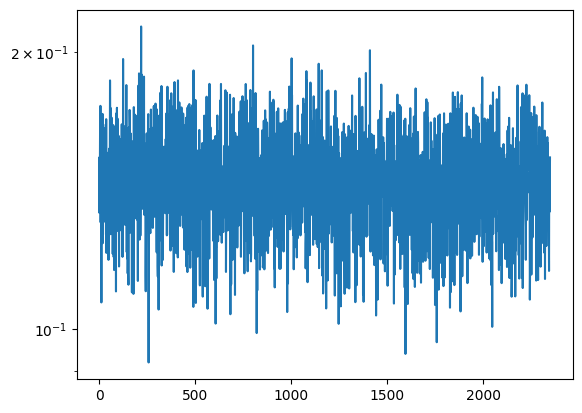

In [17]:
losses = trainer.train()
plt.semilogy(losses)

In [19]:
diffusion.to("cuda")


Diffusion()

/home/ubuntu/.cache/pypoetry/virtualenvs/tiny-text-to-3d-c32y3Mwx-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  2%|▏         | 16/1000 [00:00<00:06, 152.94it/s]

100%|██████████| 1000/1000 [00:06<00:00, 148.06it/s]


torch.Size([100, 2, 32])


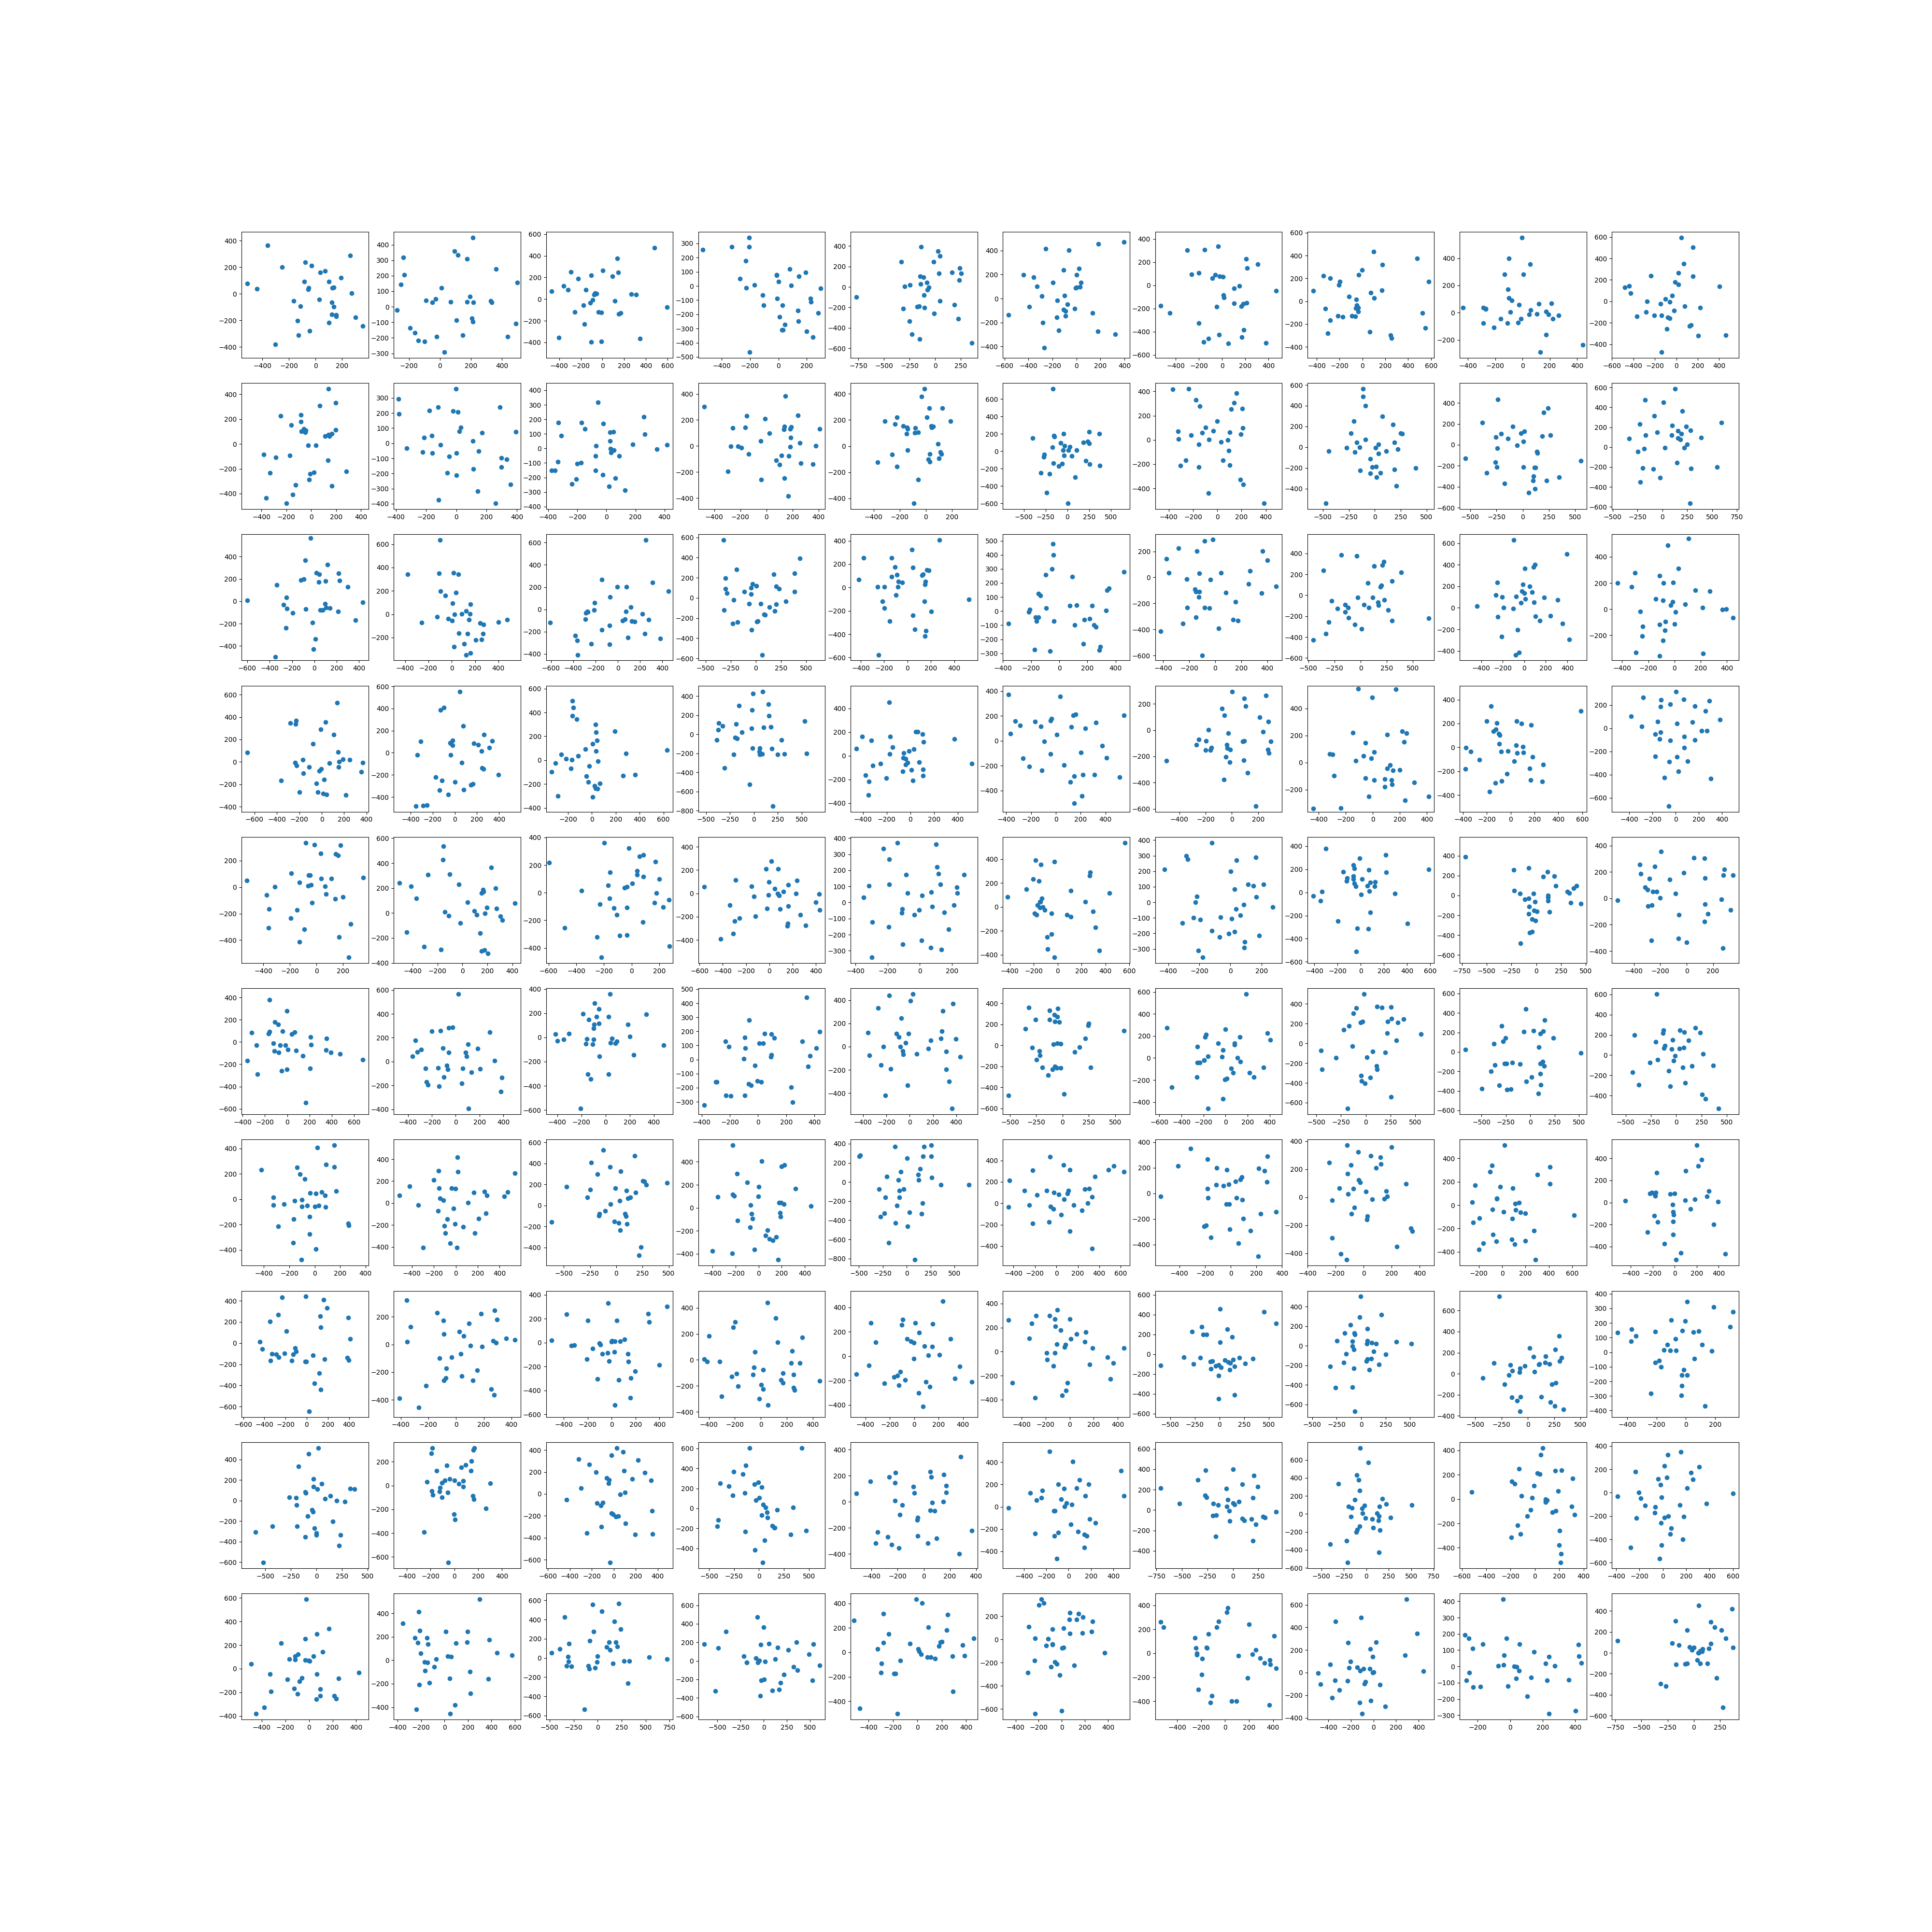

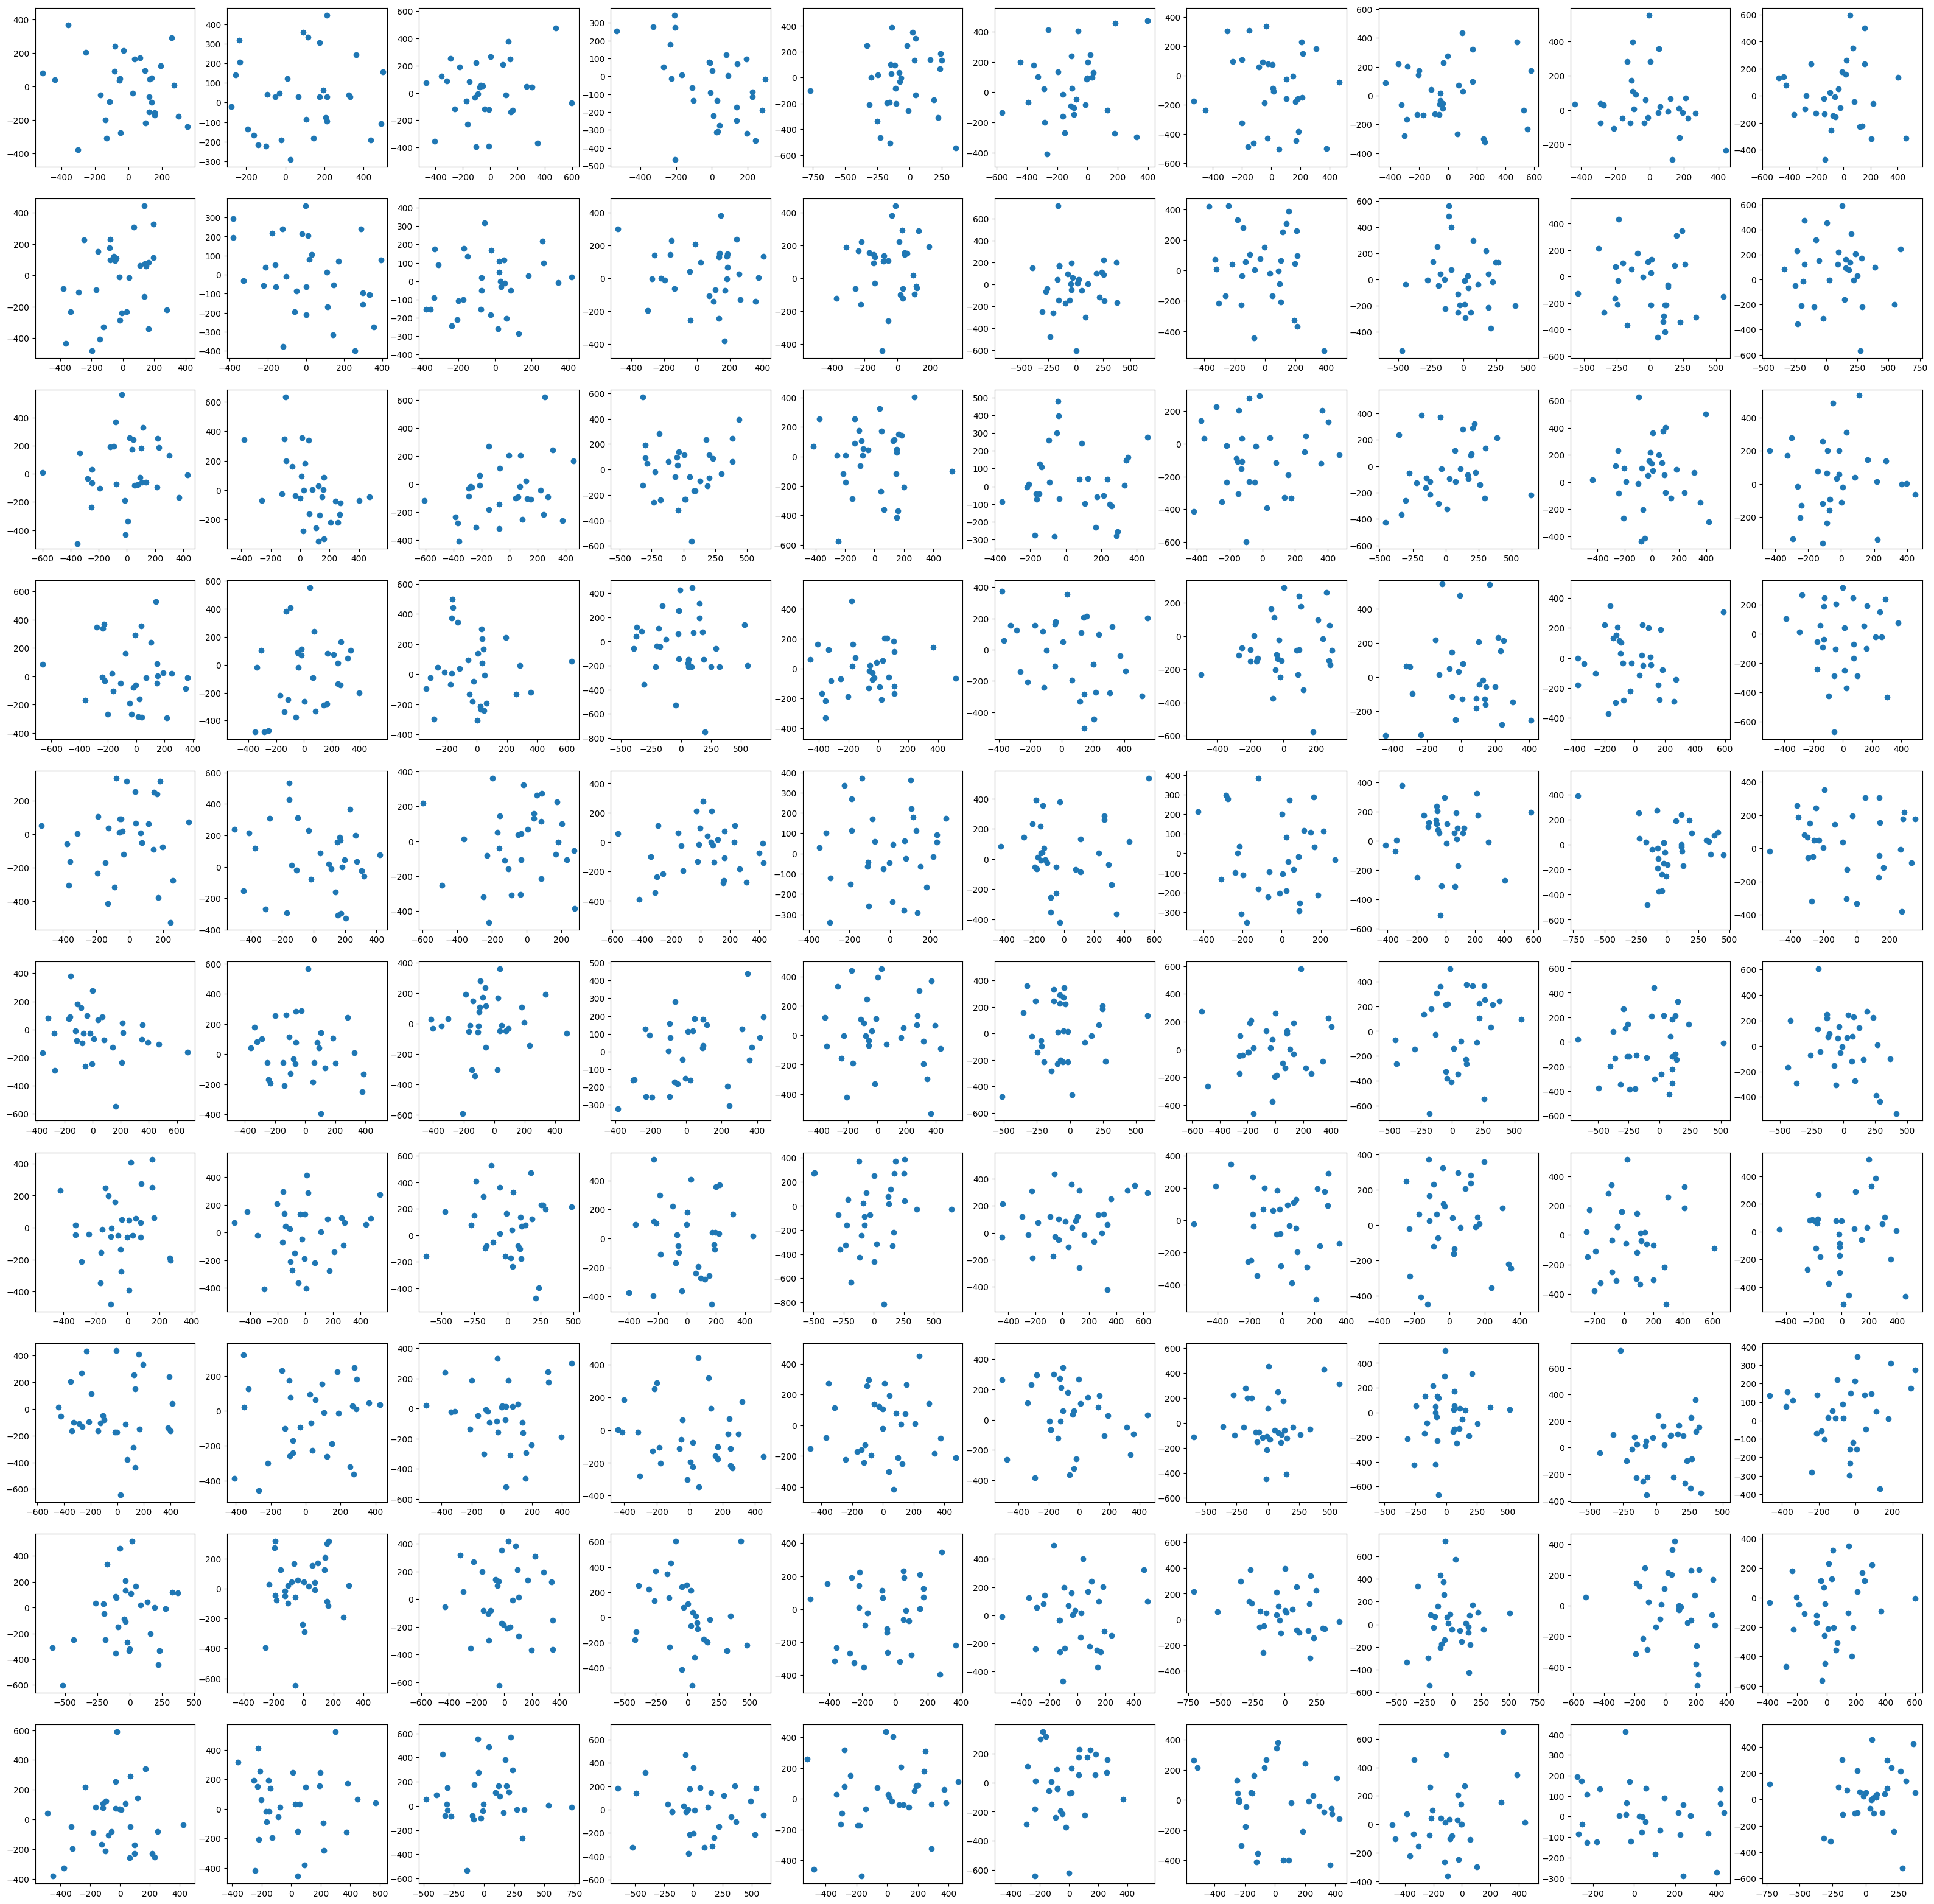

In [22]:
sample = gaussian_diffusion.p_sample_loop(dit, (100, 2, num_points), progress=True)
# sample = diffusion.p_sample_loop(dit, (100, 2, num_points), clip_denoised=True)
# sample = diffusion.p_sample_loop(dit, (100, num_points, 2), clip_denoised=False)
print(sample.shape)
sample = sample.permute(0, 2, 1)
plot_point_clouds(sample, 10, 10)

In [12]:
sample.shape

torch.Size([100, 2, 16])